Group Contribution: Ravi Das Vaishnav / Shreya Agarwal

#Code 2- LIGHTER MODEL
###Target:
  1.   Make the model Lighter by reducing the number of parameter.
###Results:
  1.   Parameters: 13.7k
  2.   Best Train Accuracy: 99.06
  3.   Best Test Accuracy: 98.63
###Analysis:
  1.   The model is still large, but working
  2.   We see some over-fitting




#Import Libraries


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#Data Transformations

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])

#Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

#Dataloader Arguments & Test/Train Dataloaders



In [22]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#Data Statistics

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


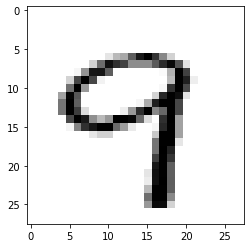

In [23]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


#The model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26 and RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24 and RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22 and RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  and RF = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11 and RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9  and RF = 12
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 and RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 and RF = 16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1  and RF = 38

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#Model Params

In [25]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,304
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,304
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             160
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 16, 9, 9]           1,440
             ReLU-11             [-1, 16, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           2,304
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [

#Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#Let's Train and test our model

In [27]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.2931668758392334 Batch_id=468 Accuracy=17.21: 100%|██████████| 469/469 [00:10<00:00, 45.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2932, Accuracy: 2968/10000 (29.68%)

EPOCH: 1


Loss=0.17603139579296112 Batch_id=468 Accuracy=86.42: 100%|██████████| 469/469 [00:10<00:00, 45.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1220, Accuracy: 9637/10000 (96.37%)

EPOCH: 2


Loss=0.15441207587718964 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:10<00:00, 45.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9753/10000 (97.53%)

EPOCH: 3


Loss=0.06668808311223984 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:09<00:00, 46.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9794/10000 (97.94%)

EPOCH: 4


Loss=0.13043436408042908 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9834/10000 (98.34%)

EPOCH: 5


Loss=0.043812621384859085 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:10<00:00, 45.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9828/10000 (98.28%)

EPOCH: 6


Loss=0.03871758654713631 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:10<00:00, 46.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9835/10000 (98.35%)

EPOCH: 7


Loss=0.025340303778648376 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 43.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9855/10000 (98.55%)

EPOCH: 8


Loss=0.06474798917770386 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:10<00:00, 45.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9852/10000 (98.52%)

EPOCH: 9


Loss=0.02969798445701599 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:10<00:00, 45.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9841/10000 (98.41%)

EPOCH: 10


Loss=0.12749335169792175 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:10<00:00, 45.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9863/10000 (98.63%)

EPOCH: 11


Loss=0.034680724143981934 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:10<00:00, 45.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9861/10000 (98.61%)

EPOCH: 12


Loss=0.04609192535281181 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:10<00:00, 46.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9844/10000 (98.44%)

EPOCH: 13


Loss=0.04530005529522896 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:09<00:00, 46.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9861/10000 (98.61%)

EPOCH: 14


Loss=0.020389536395668983 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 46.44it/s]



Test set: Average loss: 0.0417, Accuracy: 9862/10000 (98.62%)

